In [2]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from utils import *

MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'adult'
seed = 1
np.random.seed(seed)

In [3]:
from ctgan import load_demo
data = load_demo()

categorical_features = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
]


In [4]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.858


Epoch 1, Loss G: 0.017814151493017752, loss_bb: 0.017814151493017752
Epoch 2, Loss G: 0.01768021799468135, loss_bb: 0.01768021799468135
Epoch 3, Loss G: 0.01765660226860586, loss_bb: 0.01765660226860586
Epoch 4, Loss G: 0.01754974249983575, loss_bb: 0.01754974249983575
Epoch 5, Loss G: 0.017237063721902104, loss_bb: 0.017237063721902104


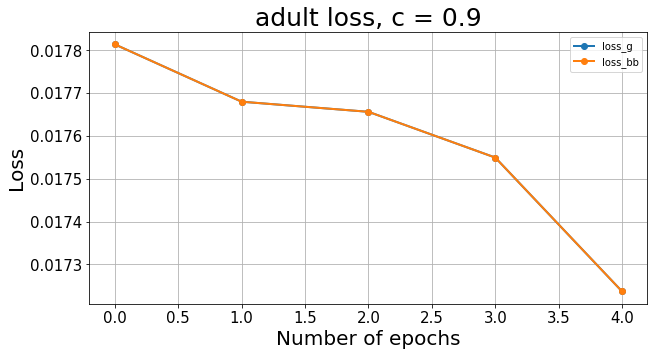

In [8]:
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))
batch_size = 500
epochs = 5
confidence_level = 0.9 
gen_lr = 2e-5
loss = 'focal'

rf_ctgan = CTGANSynthesizer(batch_size=batch_size, 
                            blackbox_model=rf, 
                            preprocessing_pipeline=preprocessor, 
                            bb_loss=loss
                            )

hist = rf_ctgan.fit(train_data=z, 
                    epochs=epochs,
                    confidence_level=confidence_level,
                    gen_lr=gen_lr,
                    )

# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")

plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
print()

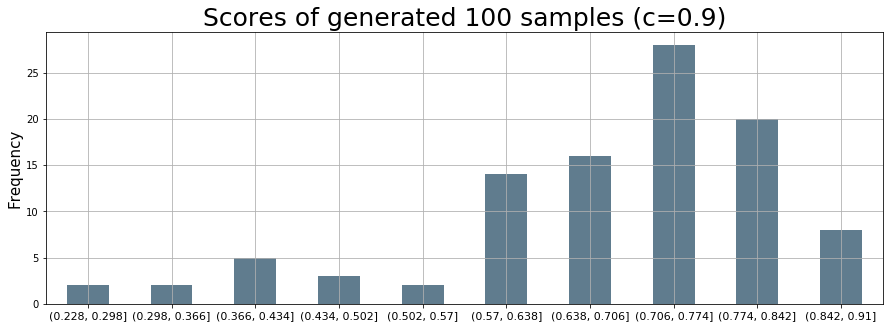

In [9]:
# check confidence for the generated samples
samples = 100
confidence_levels = [confidence_level]

for c in confidence_levels:
#     rf_ctgan = CTGANSynthesizer.load(f"{MODELS_PATH}/ctgan_c_{c}.pkl")
    gen_data = rf_ctgan.sample(samples)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores

    counts = pd.value_counts(y_conf_gen, bins=10, sort=False)
    plt.figure()
    ax = counts.plot.bar(rot=0, grid=True, color='#607c8e', figsize=(15,5))
    ax.set_xticklabels([str(interval) for interval in counts.index], fontsize=11)
    ax.set_ylabel('Frequency', fontsize=15)

    ax.set_title(f'Scores of generated {samples} samples (c={c})', fontsize=25)

In [10]:
# find samples s such that s.confidence > c
indecies = np.argwhere(y_conf_gen>confidence_level).squeeze()
print(f"indecies:\n\t{indecies}\nconfidence levels:\n\t{y_conf_gen[indecies]}")
indecies = indecies if indecies.shape != () else [indecies] # avoide no shape arrays

indecies:
	[89 97]
confidence levels:
	[0.91 0.91]


In [12]:
gen_data

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,-0.277706,1.175201,-3.113065,-0.584447,-0.465091,0.739310,0.424274,0.150413,0.249698,-0.582762,...,0.194314,-1.731950,-1.448968,0.909292,-0.589350,0.683042,-1.239607,0.953306,-0.826268,0.475331
1,0.927780,-0.540447,-0.491932,0.638267,2.731836,0.082978,0.499608,-0.653490,0.535057,-0.388294,...,-1.245343,0.254265,-0.324120,0.294692,-0.057145,-0.909445,-0.127364,-0.843392,-0.840147,-0.338562
2,-2.347966,-2.596228,-0.739305,1.693695,-0.220199,-0.112143,0.424579,-0.848107,-0.038452,-1.469471,...,-1.508190,0.269226,-1.644482,1.342194,-1.372640,-1.947738,0.260375,-0.293895,0.412214,0.861510
3,-0.350740,0.648446,-0.543351,0.014470,-0.022740,1.793186,1.379613,-1.818028,1.961096,2.491825,...,-1.155917,-0.933768,2.802847,-0.173672,1.603529,0.074512,0.002297,-0.660208,-0.128952,0.188039
4,0.297828,3.640857,-0.783291,1.377201,0.640447,-1.163558,-1.445193,-0.128753,0.529928,1.582785,...,1.349448,1.458138,-0.185887,-0.142859,0.057132,0.195221,-1.459832,-0.982557,-0.396396,-0.502594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.566610,-0.342406,-0.751433,-0.595687,-2.449823,1.485331,0.076068,-1.432309,0.368462,-0.152326,...,0.414667,-0.572964,0.358919,-0.814364,0.463118,0.357780,-2.388857,-0.066164,1.879309,1.473437
96,0.583163,-0.313906,-2.700833,1.674747,-0.922040,-0.821271,0.804049,1.806986,1.385161,0.785105,...,-1.084398,0.134265,1.025096,0.210325,-2.717926,0.140136,0.232494,-1.460594,-2.385636,1.968722
97,2.412704,0.221377,-0.004176,0.845125,-0.906511,-3.514618,-1.295961,-0.016921,0.951401,0.579663,...,-2.022854,-0.682284,-0.598904,0.874247,-1.201663,0.502693,-2.449523,-3.540357,-3.102853,-0.558743
98,0.002268,-0.294604,-0.463262,0.003630,1.129406,1.724135,-3.810443,0.215347,3.037900,-0.412712,...,0.306297,-0.622337,0.520286,0.249129,-0.317239,0.334683,-1.180448,-1.085260,0.138530,-2.100056


In [ ]:
# inverse the generated data
scaler = get_scaler(preprocessor)
gen_data_above_c_before = gen_data.iloc[indecies]
gen_data_above_c = pd.DataFrame(scaler.inverse_transform(gen_data_above_c_before))

In [ ]:
euclidean_scores, cosine_scores = calc_scores(gen_data_above_c, X_train)
print(f"euclidean_scores:\n\t{euclidean_scores}")
print(f"cosine_scores:\n\t{cosine_scores}")